# UCB1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Epsilon:
    """
    Agente que soluciona el problema del el Bandido Multibrazo
    (Multi-Armed Bandit) mediante el uso de una estrategia Epsilon
    Greedy
    
    Parámetros
    ----------
    bandits : array of Bandit
        Vector con los bandidos con los que se debe jugar
    epsilon : float
        Porcentaje de veces en las que el agente jugada de forma
        aleatoria
    decay : float
        Velocidad con la que decae la probabilidad de seleccionar una
        jugada al azar
    initial: array of float
        Valor inicial de la recompensa esperada para cada uno de
        bandidos
    Métodos
    -------
    run :
        Realiza una tirada en el bandido
    average_reward :
        Obtención de la recompensa promedio
    plot :
        Representación gráfica del histórico de jugadas
    reset :
        Reinicia el agente
    """
    
    def __init__(self, bandits, epsilon=0.05, decay=1, initial=None):
        self.bandits = bandits
        self.epsilon = epsilon
        self.decay = decay
        self.reset(initial)
        
        
    def run(self, episodes=1):
        for i in range(episodes):
            prob = np.random.random()
            
            # Selección entre la jugada aleatoria o avariciosa
            if prob < self._epsilon:
                bandit = np.random.choice(len(bandits))
            else:
                max_bandits = np.where(self._mean == np.max(self._mean))[0]
                bandit = np.random.choice(max_bandits)

            # Decaimiento del parámetro epsilon
            self._epsilon *= self.decay
            
            # Obtención de una nueva recompensa
            reward = bandits[bandit].pull()
            
            # Agregación de la recompensa al listado
            self._rewards.append(reward)
            
            # Actualización de la media
            self._plays[bandit] += 1
            self._mean[bandit] = (1 - 1.0/self._plays[bandit]) * self._mean[bandit] \
                                 + 1.0/self._plays[bandit] * reward
        
        return self.average_reward()
    
    
    def average_reward(self):
        return np.mean(self._rewards)
    
    
    def plot(self, log=False, reference=False, label=None):
        cumulative_average = np.cumsum(self._rewards) / (np.arange(len(self._rewards)) + 1)
        
        if label is None:
            plt.plot(range(len(self._rewards)), cumulative_average)
        else:
            plt.plot(range(len(self._rewards)), cumulative_average, label=label)
            
        if reference:
            for reward in [b.reward for b in self.bandits]:
                plt.plot([0, len(self._rewards)], [reward, reward],
                         label=f'reward={reward}')
                
        if log:
            plt.xscale('log')
    
    
    def reset(self, initial=None):
        self._rewards = []
        
        if initial is None:
            self._epsilon = self.epsilon
            self._plays = [0] * len(self.bandits)
            self._mean = [0] * len(self.bandits)
        else:
            self._epsilon = 0
            self._plays = [1] * len(self.bandits)
            self._mean = initial

In [5]:
class Bandit:
    """
    Implementación de un Bandido Multibrazo (Multi-Armed Bandit) basado
    en una distribución binomial

    Parámetros
    ----------
    number: integer
        Número de recompensas que puede devolver el agente
    probability : float
        Probabilidad de que el objeto devuelva una recompensa
    
    Métodos
    -------
    pull :
        Realiza una tirada en el bandido
        
    """
    def __init__(self, probability, number=1):
        self.number = number
        self.probability = probability
        self.reward = self.number * self.probability
        
        
    def pull(self):        
        return np.random.binomial(self.number, self.probability) 
        

In [6]:
class UCB(Epsilon):
    def __init__(self, bandits):
        self.bandits = bandits
        
        self.reset()
    def run(self, episodes=1):
        for i in range(episodes):
            # Selección del bandido
            bandit = self.select()
            
            # Obtención de una nueva recompensa
            reward = bandits[bandit].pull()
            
            # Agregación de la recompensa al listado
            self._rewards.append(reward)
            
            # Actualización de la media
            self._rewards2[bandit] += reward ** 2
            self._plays[bandit] += 1
            self._mean[bandit] = (1 - 1.0/self._plays[bandit]) * self._mean[bandit] \
                                 + 1.0/self._plays[bandit] * reward
        
        return self.average_reward()
    def select(self):
        num_bandits = len(self.bandits)
        total = len(self._rewards)
        
        if total == 0:
            bandit = np.random.choice(len(bandits))
        else:
            ucb = [0] * num_bandits
            
            for i in range(num_bandits):
                if self._plays[i] == 0:
                    ucb[i] = self._mean[i] + np.sqrt(2 * np.log(total))
                else:
                    ucb[i] = self._mean[i] + np.sqrt(2 * np.log(total) / self._plays[i])
        
            max_bandits = np.where(ucb == np.max(ucb))[0]
            bandit = np.random.choice(max_bandits)
            
        return bandit
    
    
    def reset(self, initial=None):
        self._rewards = []
        self._plays = [0] * len(self.bandits)
        self._mean = [0] * len(self.bandits)
        self._rewards2 = [0] * len(self.bandits)

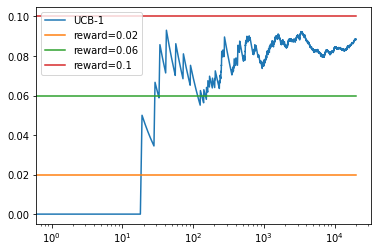

In [7]:
np.random.seed(0)

bandits = [Bandit(0.02), Bandit(0.06), Bandit(0.10)]

ucb_1 = UCB(bandits)
ucb_1.run(20000)
ucb_1.plot(True, True, label='UCB-1')
plt.legend()

# UCB1-Normal:
El método UCB1-Normal es una mejora de UCB1 en el que se asume que las recompensas de cada uno de los bandidos son generadas mediante una distribución Normal. Lo que permite seleccionar al mejor bandido en base al nivel de confianza que se deduce de esta distribución. Minimizando de este modo el número de tiradas en fase de exploración.

Una de las características de este UCB1-Normal es el hecho de garantizar un mínimo de jugadas para cada uno de los bandidos. Evitando de este modo que algunos de los bandidos no se exploren debido a una mala racha inicial. Aunque esto puede conllevar una menor explotación de los resultados.

In [8]:
class UCBNormal(Epsilon):
    def __init__(self, bandits):
        self.bandits = bandits
        
        self.reset()
    
    def run(self, episodes=1):
        for i in range(episodes):
            # Selección del bandido
            bandit = self.select()
            
            # Obtención de una nueva recompensa
            reward = bandits[bandit].pull()
            
            # Agregación de la recompensa al listado
            self._rewards.append(reward)
            
            # Actualización de la media
            self._rewards2[bandit] += reward ** 2
            self._plays[bandit] += 1
            self._mean[bandit] = (1 - 1.0/self._plays[bandit]) * self._mean[bandit] \
                                 + 1.0/self._plays[bandit] * reward
        
        return self.average_reward()
    
    
    def select(self):
        num_bandits = len(self.bandits)
        total = len(self._rewards)
        
        # Número de veces mínimo que debe jugar cada bandido
        if total > 0:
            min_plays = np.ceil(8 * np.log(total))
        else:
            min_plays = 1
        
        # En caso de que algún bandido no jugase el mínimo de veces se selecciona ese
        if np.any(np.array(self._plays) < min_plays):
            min_bandit = np.where(np.array(self._plays) < min_plays)[0]
            bandit = np.random.choice(min_bandit)
        else:
            ucb = [0] * num_bandits
            
            for i in range(num_bandits):
                if self._plays[i] > 1:
                    bonus = 16 * (self._rewards2[i] - self._plays[i] * self._mean[i]**2) / (self._plays[i] - 1)
                    bonus *= np.log(total - 1) / self._plays[i]
                    bonus = np.sqrt(bonus)
                    ucb[i] = self._mean[i] + bonus
                else:
                    ucb[i] = self._mean[i]
                    
            max_bandits = np.where(ucb == np.max(ucb))[0]
            bandit = np.random.choice(max_bandits)
            
        return bandit
    
    
    def reset(self, initial=None):
        self._rewards = []
        self._plays = [0] * len(self.bandits)
        self._mean = [0] * len(self.bandits)
        self._rewards2 = [0] * len(self.bandits)

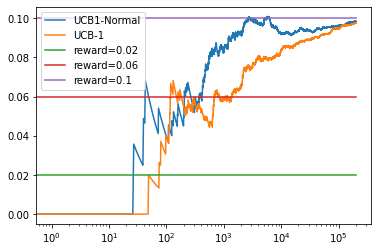

In [9]:
np.random.seed(0)

bandits = [Bandit(0.02), Bandit(0.06), Bandit(0.10)]

ucb_n = UCBNormal(bandits)
ucb_1 = UCB(bandits)

ucb_n.run(200000)
ucb_1.run(200000)
ucb_n.plot(True, label='UCB1-Normal')
ucb_1.plot(True, True, label='UCB-1')
plt.legend()

In [10]:
print('UCB-Normal jugadas: ',ucb_n._plays)
print('UCB-1 jugadas: ',ucb_1._plays)

UCB-Normal jugadas:  [494, 5854, 193652]
UCB-1 jugadas:  [2883, 8807, 188310]
